# Logistic Regression

In [1]:
!gcloud auth login

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?code_challenge=WZJNK6FeH5khpokLgpgyJWL0oky_f3L1yjQ2QUQdDW4&prompt=select_account&code_challenge_method=S256&access_type=offline&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&response_type=code&client_id=32555940559.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth


If you need to use ADC, see:
  gcloud auth application-default --help

You are now logged in as [galli.giuly@gmail.com].
Your current project is [reddit-master].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


In [1]:
!gcloud config set project reddit-master

Updated property [core/project].


In [2]:
!gsutil ls gs://reddit_models

gs://reddit_models/model_fasttext_atheism
gs://reddit_models/model_lr.joblib
gs://reddit_models/model_svm.joblib
gs://reddit_models/red_model_lrc.pkl
gs://reddit_models/red_model_lstm_20_batchsize_150.h5
gs://reddit_models/red_model_lstm_30_batchsize_150_10_subreddits.h5
gs://reddit_models/red_model_lstm_30_batchsize_512.h5
gs://reddit_models/red_model_lstm_30_batchsize_512_v2.h5
gs://reddit_models/red_model_rfc.pkl
gs://reddit_models/red_model_svm.pkl
gs://reddit_models/tokenizer_keras.pkl
gs://reddit_models/fastext_files/


In [5]:
import pandas as pd
import numpy as np
import pickle as pkl
import nltk.data
import joblib
import nltk
import ast
import logging


from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
import datetime
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/pepe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
def loggg(msg):
    print("[INFO] {}: {}".format(datetime.datetime.now(), msg))

In [5]:
!gsutil cp gs://reddit_final_results/red_comments_posts_tokenized.pkl .

Copying gs://reddit_final_results/red_comments_posts_tokenized.pkl...
- [1 files][358.1 MiB/358.1 MiB]    3.3 MiB/s                                   
Operation completed over 1 objects/358.1 MiB.                                    


In [7]:
red_model_LR_df = pd.read_pickle("red_comments_posts_tokenized.pkl")

In [8]:
red_model_LR_df.head()

,subreddit,body,subreddit_id
0,funny,"[hell, job, blue, duck, photo, sourc]",5
1,funny,"[one, settl]",5
2,funny,"[grand, father, fish, cod, like, 50, year, ago]",5
3,funny,"[fake, yes, , effect, real]",5
4,funny,"[smoke, bomb, bug, poison, combin]",5


In [9]:
X = red_model_LR_df['body']
y = red_model_LR_df['subreddit_id']

# Definint a fucntion that slit the dataset into three subsets: train, val and test
def train_dev_test_split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    return dict(X_train=X_train,
                X_test=X_test,
                y_train=y_train.astype('int'),
                y_test=y_test.astype('int'))

In [11]:
red_model_LR_df_split = train_dev_test_split(X,y)

In [16]:
parameters = {
"tfidf__max_df": [0.25, 0.5, 0.75],
"tfidf__ngram_range": [(1, 1), (1, 2)],
"clf__estimator__class_weight": ["balanced",None]
}

In [19]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=" ".join)),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='sag', multi_class='auto')))
    ])


grid_search_tune = GridSearchCV(pipeline, parameters, cv=2, n_jobs=4, verbose=10)

In [20]:
loggg("pipeline created")

grid_search_tune.fit(red_model_LR_df_split['X_train'], red_model_LR_df_split['y_train'].to_numpy().astype('int'))

[INFO] 2019-11-29 23:15:33.056553: pipeline created
Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed: 52.0min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 92.6min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed: 129.7min
[Parallel(n_jobs=4)]: Done  20 out of  24 | elapsed: 133.5min remaining: 26.7min
[Parallel(n_jobs=4)]: Done  24 out of  24 | elapsed: 144.2min finished
/nix/store/q3c697cny5xlaax78zvhapdslfpq08i5-python3.7-scikit-learn-0.21.3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                         

In [21]:
# measuring performance on test set
loggg('Best parameters set:')
print(grid_search_tune.best_estimator_.steps)
# measuring performance on test set
loggg('Applying best classifier on test data:')

[INFO] 2019-11-30 09:23:37.165910: Best parameters set:
[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.75, max_features=None,
                min_df=1, ngram_range=(1, 2), norm='l2',
                preprocessor=<built-in method join of str object at 0x7f3d7beea970>,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)), ('clf', OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 mu

In [22]:
best_clf = grid_search_tune.best_estimator_
best_clf

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.75, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=<built-in method join of str object at 0x7f3d7beea970>,
                                 smooth_idf=True, stop_words=None,
                                 strip_acc...
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 OneVsRestClassifier(estimator=LogisticRegression(C=1.0,
                                                                  class_weight='balanced',
                           

In [28]:
grid_search_tune.best_params_

{'clf__estimator__class_weight': 'balanced',
 'tfidf__max_df': 0.75,
 'tfidf__ngram_range': (1, 2)}

In [27]:
grid_search_tune.best_score_

0.5254567389872479

In [25]:
predictions = best_clf.predict(red_model_LR_df_split['X_test'])
print(classification_report(red_model_LR_df_split['y_test'], predictions))

              precision    recall  f1-score   support

           0       0.80      0.85      0.83     46567
           1       0.43      0.38      0.40     46567
           2       0.58      0.61      0.59     46567
           3       0.59      0.65      0.62     46097
           4       0.57      0.57      0.57     46567
           5       0.30      0.31      0.31     46567
           6       0.62      0.60      0.61     46567
           7       0.64      0.66      0.65     46568
           8       0.81      0.80      0.81     46567
           9       0.47      0.49      0.48     46257
          10       0.47      0.55      0.51     46125
          11       0.52      0.56      0.54     46164
          12       0.30      0.24      0.26     46093
          13       0.37      0.30      0.33     46098

    accuracy                           0.54    649371
   macro avg       0.53      0.54      0.54    649371
weighted avg       0.53      0.54      0.54    649371



In [31]:
with open('red_model_lrc.pkl', 'wb') as file:
    pkl.dump(best_clf, file)

In [32]:
!gsutil cp red_model_lrc.pkl gs://reddit_models/

Copying file://red_model_lrc.pkl [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

- [1 files][  1.7 GiB/  1.7 GiB]    4.5 MiB/s                                   
Operation completed over 1 objects/1.7 GiB.                                      


# Testing the accuracy of the model

In [2]:
!gsutil cp gs://reddit_models/red_model_lrc.pkl .

Copying gs://reddit_models/red_model_lrc.pkl...
- [1 files][  1.7 GiB/  1.7 GiB]    3.0 MiB/s                                   
Operation completed over 1 objects/1.7 GiB.                                      


In [12]:
with open('red_model_lrc.pkl', 'rb') as file:
    red_model_lrc = pkl.load(file)

prediction = red_model_lrc.predict(red_model_LR_df_split['X_test'])

print(classification_report(red_model_LR_df_split['y_test'], prediction))

              precision    recall  f1-score   support

           0       0.80      0.85      0.83     46567
           1       0.43      0.38      0.40     46567
           2       0.58      0.61      0.59     46567
           3       0.59      0.65      0.62     46097
           4       0.57      0.57      0.57     46567
           5       0.30      0.31      0.31     46567
           6       0.62      0.60      0.61     46567
           7       0.64      0.66      0.65     46568
           8       0.81      0.80      0.81     46567
           9       0.47      0.49      0.48     46257
          10       0.47      0.55      0.51     46125
          11       0.52      0.56      0.54     46164
          12       0.30      0.24      0.26     46093
          13       0.37      0.30      0.33     46098

    accuracy                           0.54    649371
   macro avg       0.53      0.54      0.54    649371
weighted avg       0.53      0.54      0.54    649371



In [13]:
accuracy_score(red_model_LR_df_split['y_test'], prediction)

0.5403629050265565

# Visualization

In [20]:
conf = confusion_matrix(prediction, red_model_LR_df_split['y_test'])

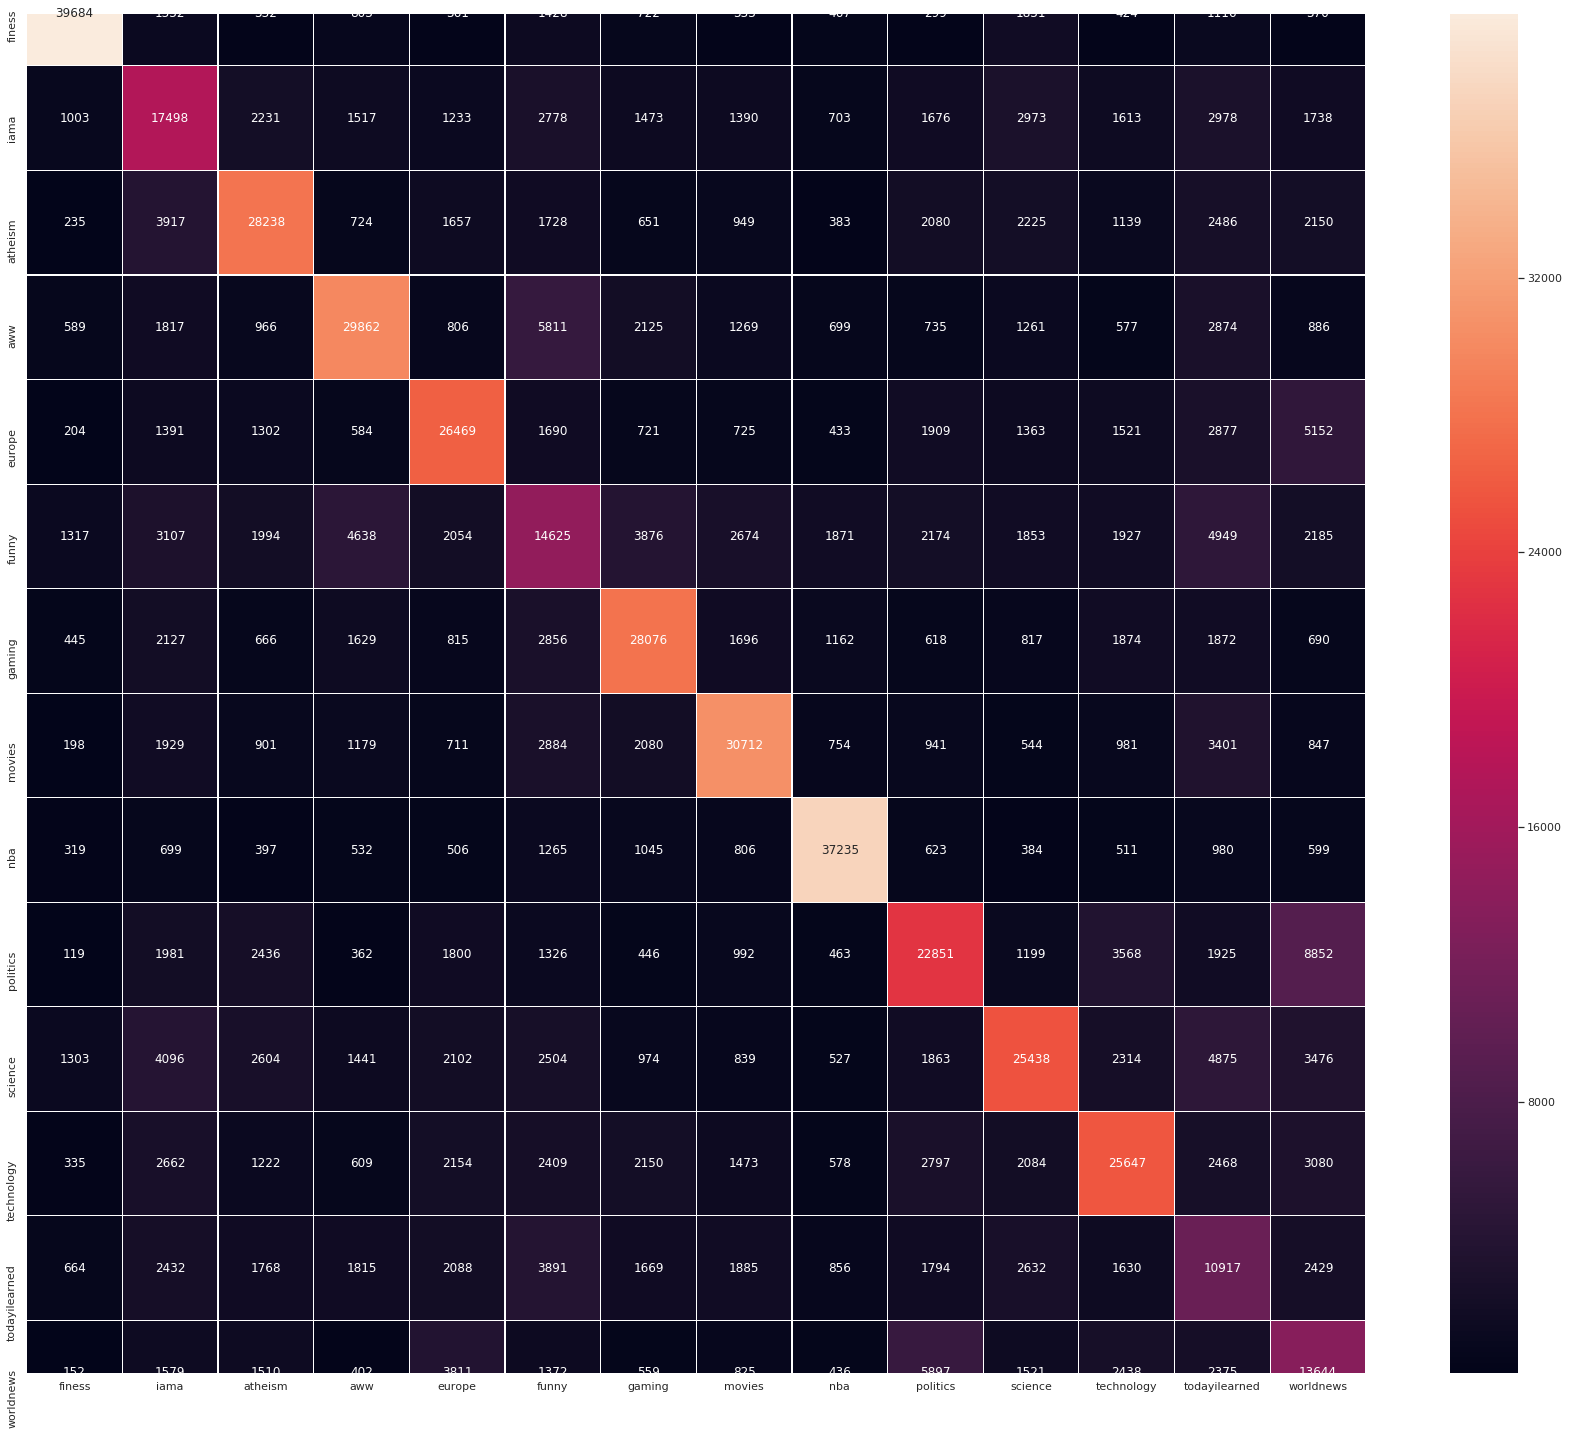

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

subreddits = [
    'finess',
    'iama',
    'atheism',
    'aww',
    'europe',
    'funny',
    'gaming',
    'movies',
    'nba',
    'politics',
    'science',
    'technology',
    'todayilearned',
    'worldnews'
]

plt.figure(figsize =(30, 25))

sns.heatmap(conf, annot=True, linewidths=0.1, fmt='d', xticklabels=subreddits, yticklabels=subreddits)